<a href="https://colab.research.google.com/github/Barryjuait/Barryjuait/blob/master/Personal%20Projects/COVIDadverse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task: Exploring Covid-19 and non-Covid vaccine reports VAERS 2020

For the second interview, we would like to ask you to analyse a dataset containing reports of suspected side-effects with free-text information.
During investigations of safety concerns with medicinal products, pharmacovigilance experts will evaluate the causality between the medicinal product and the observed side effect. For this, they need as much information as possible to understand each report and what happened to that patient in as much detail as possible. They do not usually have the possibility to reach the patient and ask follow up questions. They therefore rely not only on structured information but also on the narrative descriptions of the side effect if available. These can include information about the course of events, the symptoms, the severity and quality of life of the patient but also information about concomitant factors such as other drugs or other differential diagnosis. Reports of suspected side effects can be sent by different reporters, for example the patient themselves, health care professionals or pharmaceutical companies.

For this assignment, we would like you to look at reports from VAERS in 2020, the US database for adverse events reported for vaccines. You can download it
here: https://vaers.hhs.gov/data/datasets.html. Use the CSV files VAERS DATA and VAERS VACCINE (both files contain a unique ID VAERS_ID for linking the tables). The narrative field is in the VAERS DATA file in column SYMPTOM_TEXT but there exist other free-text fields on the reports. The vaccine information can be found in the VAERS VACCINE/VAX file the column VAX_NAME contains the vaccine name for the report and you can identify the COVID19 reports using this column. Since the data is from the US in 2020, it includes reports for Covid-19 vaccines and other vaccines. The question that we would like you to answer is:

 **Are COVID-19 vaccine narratives different from narratives for other vaccines??**

Some suggestions for questions that you may want to answer during your exploration are:

* Are more or less narratives written in the first person?
* Is there more redundancy in covid-19 vaccine narratives?


Explanation of the dataset: https://vaers.hhs.gov/docs/VAERSDataUseGuide_November2020.pdf


In [1]:
import os
import glob
import pandas as pd
import numpy as np
import re
import cv2
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import groupby
from operator import itemgetter
from sklearn.metrics import silhouette_score, confusion_matrix, f1_score, classification_report, accuracy_score
from scipy.stats import kruskal, f_oneway
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, scale
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors, metrics)
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.feature_selection import (f_classif, VarianceThreshold, chi2, mutual_info_classif, SelectKBest,
                                       SelectPercentile, SelectFromModel)
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


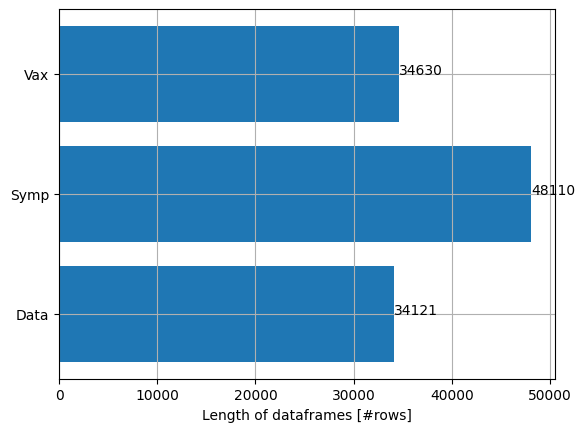

In [3]:
#open and load files:
analysisFolder = '/content/drive/MyDrive/Colab Notebooks/Pharmacovigilance/Covid_adverseRx/archive/'
picFolder = analysisFolder + 'Figs'

df_data = pd.read_csv(analysisFolder + '2021VAERSDATA.csv', delimiter=',', encoding='latin-1')
df_symp = pd.read_csv(analysisFolder + '2021VAERSSYMPTOMS.csv', delimiter=',', encoding='latin-1')
df_vax = pd.read_csv(analysisFolder + '2021VAERSVAX.csv', delimiter=',', encoding='latin-1')


x = ['Data', 'Symp', 'Vax']
y = [len(df_data), len(df_symp), len(df_vax)];
plt.barh(x, y)
for i in range(len(x)):
    plt.text(y[i], i, y[i], ha = 'left')
plt.xlabel('Length of dataframes [#rows]')
plt.grid()
plt.show()



since the dataframes contained in the files is not symetric, we will need to explore it to find the best way to merge them.

In [4]:
single_reports = np.unique(df_symp.VAERS_ID)

print(f'there are {len(single_reports)} reports and the database has {len(df_symp)} rows');

there are 34121 reports and the database has 48110 rows


In [5]:
#let's explore the data a bit:
df_symp.head(10)

,VAERS_ID,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
0,916600,Dysphagia,23.1,Epiglottitis,23.1,NaN,NaN,NaN,NaN,NaN,NaN
1,916601,Anxiety,23.1,Dyspnoea,23.1,NaN,NaN,NaN,NaN,NaN,NaN
2,916602,Chest discomfort,23.1,Dysphagia,23.1,Pain in extremity,23.1,Visual impairment,23.1,NaN,NaN
3,916603,Dizziness,23.1,Fatigue,23.1,Mobility decreased,23.1,NaN,NaN,NaN,NaN
4,916604,Injection site erythema,23.1,Injection site pruritus,23.1,Injection site swelling,23.1,Injection site warmth,23.1,NaN,NaN
5,916606,Pharyngeal swelling,23.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,916607,Abdominal pain,23.1,Chills,23.1,Sleep disorder,23.1,NaN,NaN,NaN,NaN
7,916608,Diarrhoea,23.1,Nasal congestion,23.1,NaN,NaN,NaN,NaN,NaN,NaN
8,916609,Vaccination site erythema,23.1,Vaccination site pruritus,23.1,Vaccination site swelling,23.1,NaN,NaN,NaN,NaN
9,916610,Rash,23.1,Urticaria,23.1,NaN,NaN,NaN,NaN,NaN,NaN


we group by patient ID:

In [6]:
# Merge df_data with df_symp using 'VAERS_ID' as the key
merged_df = df_data.merge(df_symp, on='VAERS_ID', how='inner')

# Merge the merged_df with df_vax using 'VAERS_ID' as the key
merged_df = merged_df.merge(df_vax, on='VAERS_ID', how='inner')

In [7]:
# Create a list of symptom columns to be melted
symptom_columns = ["SYMPTOM1", "SYMPTOM2", "SYMPTOM3", "SYMPTOM4", "SYMPTOM5"]

# Melt the DataFrame to create a long format
var = "SYMPTOMS";
melted_df = pd.melt(merged_df, id_vars=merged_df.columns.difference(symptom_columns), value_vars=symptom_columns, value_name=var)

# Drop rows with missing symptoms
melted_df = melted_df.dropna(subset=[var])

# Group by VAERS_ID and aggregate symptoms into a list
aggregated_df = melted_df.groupby("VAERS_ID")[var].agg(list).reset_index()

# Merge the aggregated symptoms back with the original data
dff = merged_df.merge(aggregated_df, on="VAERS_ID", how="inner")

# Drop duplicate columns
dff = dff.drop(columns=symptom_columns)
dff.drop_duplicates(subset = ['VAERS_ID'], inplace = True)
dff.reset_index(drop = True, inplace = True)


## Descriptive Analysis

In [8]:
print(f'This is an example of the symptoms keywords: \n{dff.SYMPTOMS[0]} \n\n...and this is an example of a full text for the same report: \n{dff.SYMPTOM_TEXT[0]}')

This is an example of the symptoms keywords: 
['Dysphagia', 'Epiglottitis'] 

...and this is an example of a full text for the same report: 
Right side of epiglottis swelled up and hinder swallowing pictures taken Benadryl Tylenol taken


In [9]:
#These are some of the most common words found in the database indicating the non-existing values:
NegL = ['NaN', 'nan', 'None', 'none', 'no known', 'Known Known', 'UKN', 'None noted', 'NA', 'Not known', 'No known allergies.', 'No known allergies', 'not known', 'notknown', 'NKA', 'NKDA', 'No', 'NO', 'none listed', 'none lister', 'NONE', 'none reported']

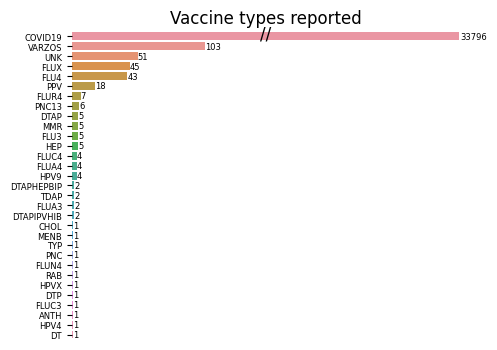

In [10]:
fig, ax = plt.subplots(1,1, figsize = (5,4), sharey = False)
hax = ax;
sns.countplot(ax = hax, data = dff, y = 'VAX_TYPE', order = dff.VAX_TYPE.value_counts().index);
hax.set(frame_on=False, xticks=[], xlabel = None, xlim = [0, 300]);
a = hax.bar_label(hax.containers[0], fontsize = 6);
hax.set_yticklabels(labels = dff.VAX_TYPE.value_counts().index, fontsize = 6)
hax.text(301, 0.25, np.sum(dff.VAX_TYPE == 'COVID19'), ha = 'left', fontsize = 6);
hax.text(150, 0.25, '//', ha = 'center', fontsize = 12);
hax.set_ylabel(None)
hax.set_title('Vaccine types reported')

plt.show()

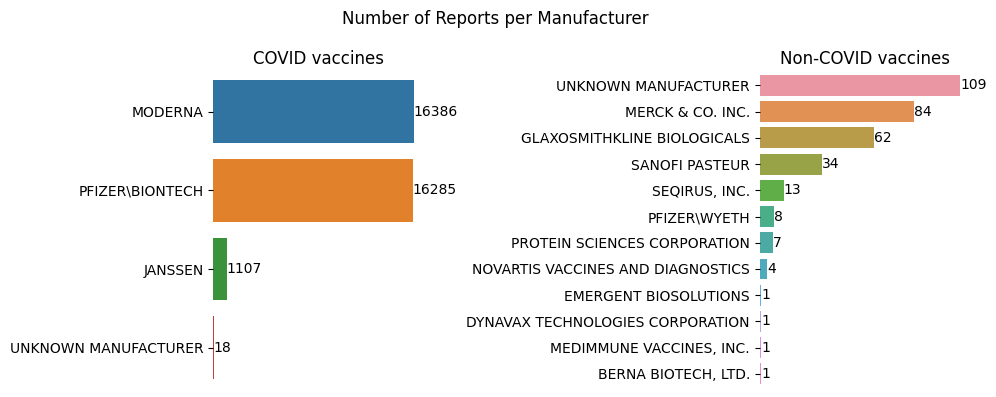

In [11]:
var = 'VAX_MANU'

fig, ax = plt.subplots(1,2, figsize = (10,4), sharey = False)
sel = (dff.VAX_TYPE == 'COVID19')
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], y = var, order = dff[var][sel].value_counts().index)
hax.set(frame_on=False, xticks=[], xlabel = None)
hax.bar_label(hax.containers[0]);
hax.set_ylabel(None)
hax.set_title('COVID vaccines')

sel = (dff.VAX_TYPE != 'COVID19')
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], y = var, order = dff[var][sel].value_counts().index)
hax.set(frame_on=False, xticks=[], xlabel = None)
hax.bar_label(hax.containers[0]);
hax.set_ylabel(None)
hax.set_title('Non-COVID vaccines')

plt.suptitle('Number of Reports per Manufacturer')
plt.tight_layout()

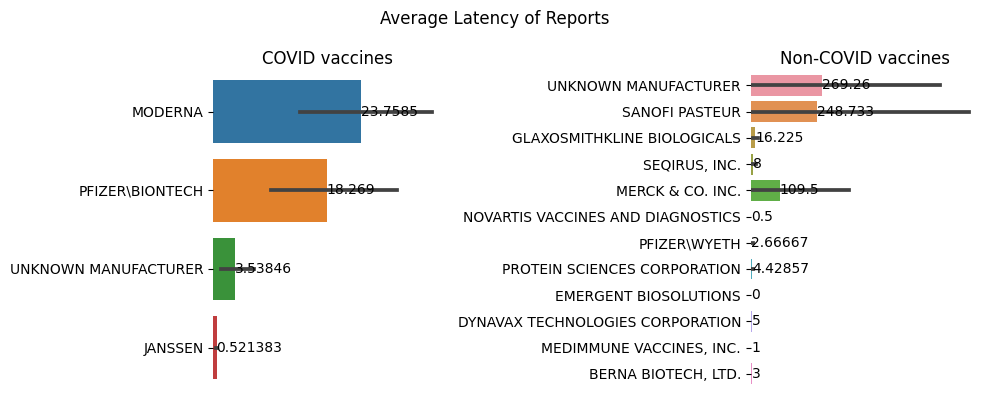

In [12]:
var = 'VAX_MANU'
var2 = 'NUMDAYS'
fig, ax = plt.subplots(1,2, figsize = (10,4), sharey = False)
sel = (dff.VAX_TYPE == 'COVID19')
hax = ax[0]
sns.barplot(ax = hax, data = dff[sel], y = var, x = var2)
hax.set(frame_on=False, xticks=[], xlabel = None)
hax.bar_label(hax.containers[0]);
hax.set_ylabel(None)
hax.set_title('COVID vaccines')

sel = (dff.VAX_TYPE != 'COVID19')
hax = ax[1]
sns.barplot(ax = hax, data = dff[sel], y = var, x = var2)
hax.set(frame_on=False, xticks=[], xlabel = None)
hax.bar_label(hax.containers[0]);
hax.set_ylabel(None)
hax.set_title('Non-COVID vaccines')

plt.suptitle('Average Latency of Reports')
plt.tight_layout()

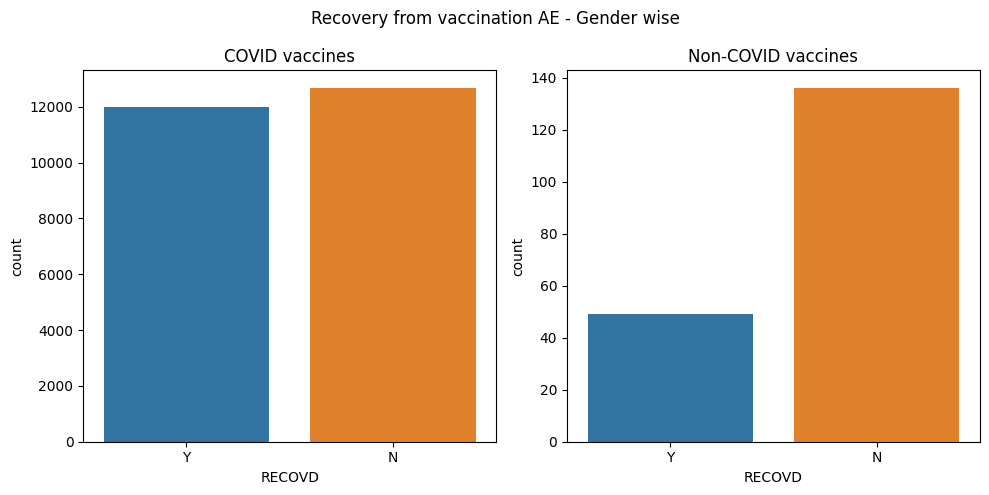

In [13]:
var = 'RECOVD'

fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = False)
sel = (dff.VAX_TYPE == 'COVID19')
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], x = var, order = ['Y', 'N'])
hax.set_title('COVID vaccines')

sel = (dff.VAX_TYPE != 'COVID19')
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], x = var, order = ['Y', 'N'])
hax.set_title('Non-COVID vaccines')
plt.suptitle('Recovery from vaccination AE - Gender wise')
plt.tight_layout()

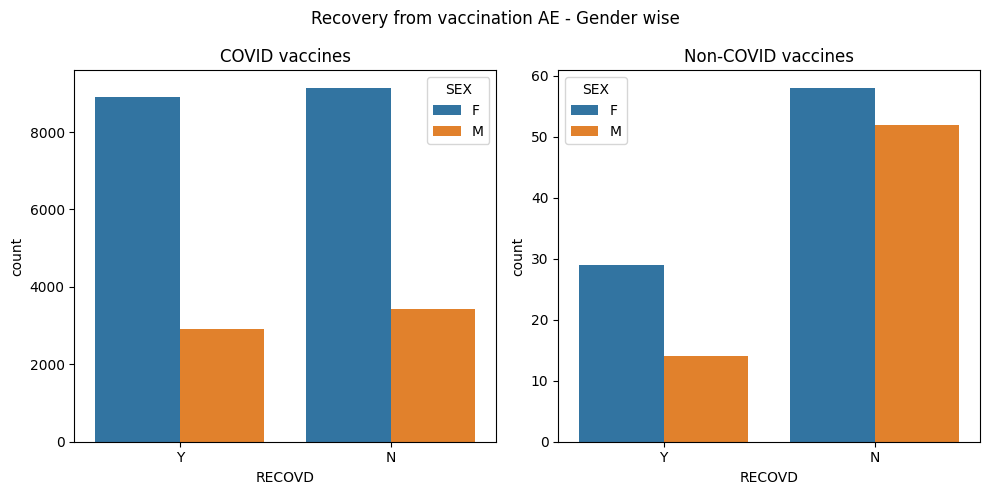

In [14]:
var = 'RECOVD'

fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = False)
sel = (dff.VAX_TYPE == 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'SEX', order = ['Y', 'N'], hue_order = ['F', 'M'])
hax.set_title('COVID vaccines')

sel = (dff.VAX_TYPE != 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'SEX', order = ['Y', 'N'], hue_order = ['F', 'M'])
hax.set_title('Non-COVID vaccines')
plt.suptitle('Recovery from vaccination AE - Gender wise')
plt.tight_layout()

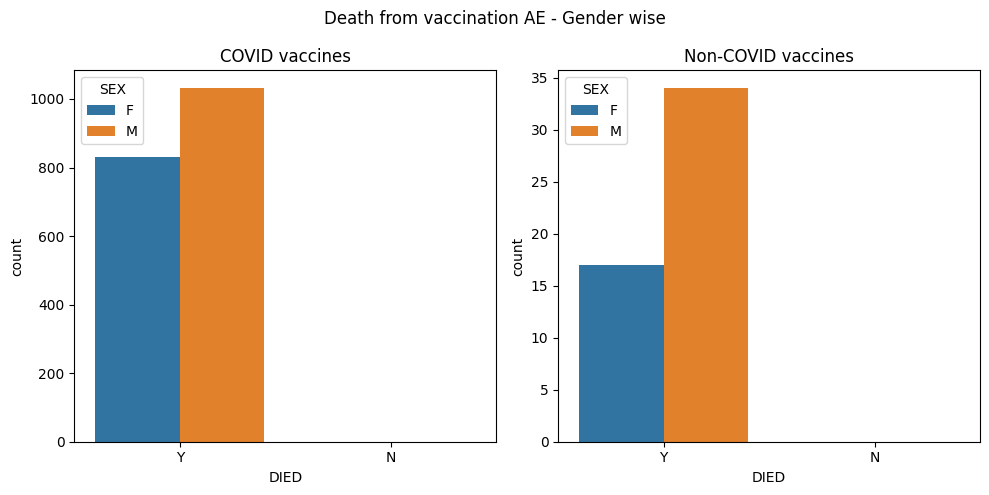

In [15]:
var = 'DIED'

fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = False)
sel = (dff.VAX_TYPE == 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'SEX', order = ['Y', 'N'], hue_order = ['F', 'M'])
hax.set_title('COVID vaccines')

sel = (dff.VAX_TYPE != 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'SEX', order = ['Y', 'N'], hue_order = ['F', 'M'])
hax.set_title('Non-COVID vaccines')
plt.suptitle('Death from vaccination AE - Gender wise')
plt.tight_layout()

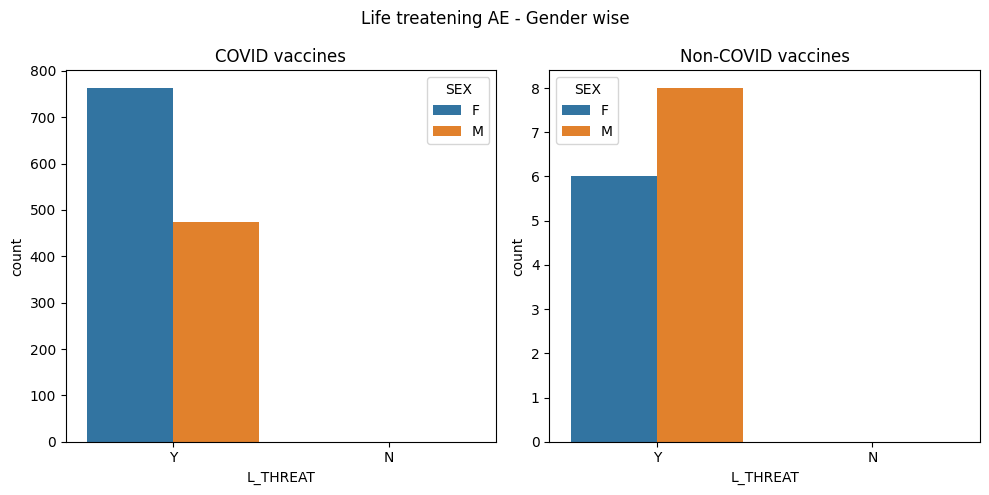

In [16]:
var = 'L_THREAT'

fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = False)
sel = (dff.VAX_TYPE == 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'SEX', order = ['Y', 'N'], hue_order = ['F', 'M'])
hax.set_title('COVID vaccines')

sel = (dff.VAX_TYPE != 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'SEX', order = ['Y', 'N'], hue_order = ['F', 'M'])
hax.set_title('Non-COVID vaccines')
plt.suptitle('Life treatening AE - Gender wise')
plt.tight_layout()

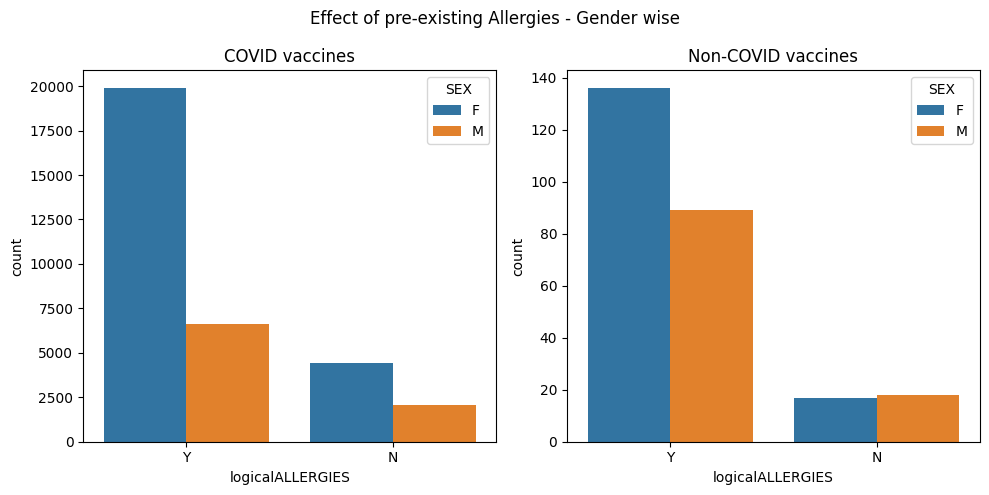

In [17]:
var = 'logicalALLERGIES'
dff[var] = np.repeat(np.nan, len(dff))
dff[var][np.in1d(dff.ALLERGIES, NegL)] = 'N'
dff[var][dff[var] != 'N'] = 'Y'

fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = False)
sel = (dff.VAX_TYPE == 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'SEX', order = ['Y', 'N'], hue_order = ['F', 'M'])
hax.set_title('COVID vaccines')

sel = (dff.VAX_TYPE != 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'SEX', order = ['Y', 'N'], hue_order = ['F', 'M'])
hax.set_title('Non-COVID vaccines')
plt.suptitle('Effect of pre-existing Allergies - Gender wise')
plt.tight_layout()

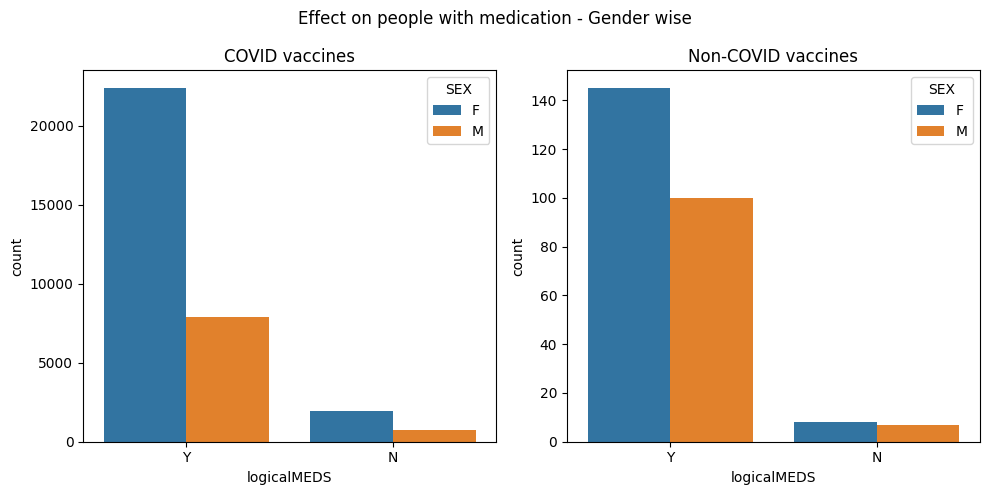

In [18]:
var = 'logicalMEDS'
dff[var] = np.repeat(np.nan, len(dff))
dff[var][np.in1d(dff.OTHER_MEDS, NegL)] = 'N'
dff[var][dff[var] != 'N'] = 'Y'

fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = False)
sel = (dff.VAX_TYPE == 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'SEX', order = ['Y', 'N'], hue_order = ['F', 'M'])
hax.set_title('COVID vaccines')

sel = (dff.VAX_TYPE != 'COVID19') & (np.in1d(dff.SEX, ['F', 'M']))
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], x = var, hue = 'SEX', order = ['Y', 'N'], hue_order = ['F', 'M'])
hax.set_title('Non-COVID vaccines')
plt.suptitle('Effect on people with medication - Gender wise')
plt.tight_layout()

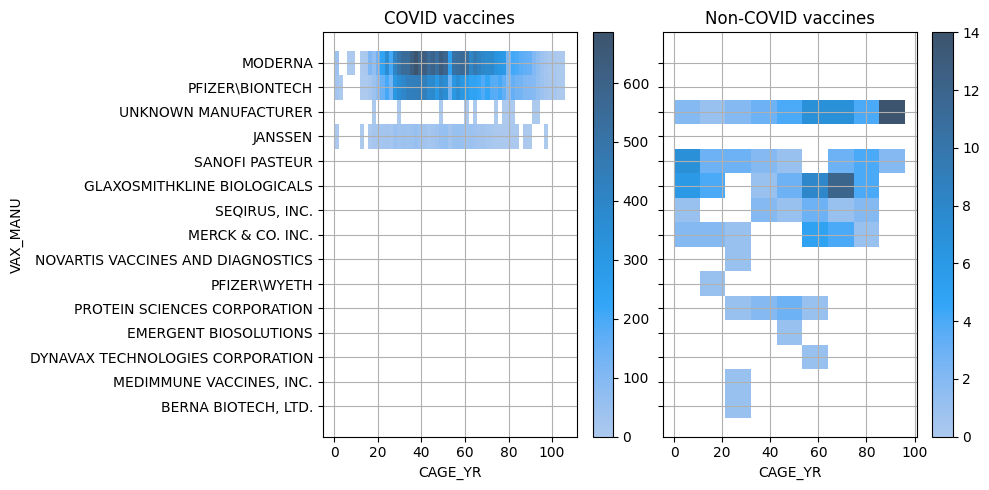

In [19]:
fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = True)
sns.histplot(ax = ax[0], data = dff[dff.VAX_TYPE == 'COVID19'], y = 'VAX_MANU', x = 'CAGE_YR', cbar = True);
ax[0].set_title('COVID vaccines')
ax[0].grid()

sns.histplot(ax = ax[1], data = dff[dff.VAX_TYPE != 'COVID19'], y = 'VAX_MANU', x = 'CAGE_YR', cbar = True);
ax[1].set_title('Non-COVID vaccines')
ax[1].grid()
plt.tight_layout();

## NLP Analysis

In [20]:
import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import re  # Import the regular expressions module

# Download NLTK resources
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('stopwords');
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords;
stopwords = stopwords.words('english') + ['of','the','to','be','that','with','on','for','by','at','one', 's', 't', 'n', 'nt', 'don', 'doesn'];

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [21]:
# Function to check if text is in first person
def is_first_person(text):
  if type(text) != str:
    output = False
  else:
    text = text.lower()
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)

    # Check if any pronouns indicate first person
    for word, pos in tagged:
        if word in ['i', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours', 'ourselves']:
          output = True
        else:
          output = False
  return output

# Apply the function to the DataFrame
dff['FirstPerson'] = dff['SYMPTOM_TEXT'].apply(is_first_person)

In [48]:
y = [np.sum(dff['FirstPerson'] == True), np.sum(dff['FirstPerson'] == False)]
print(f'Among all the {np.sum(y)} reports, {y[0]} were detected to be written in first person')

Among all the 34121 reports, 4 were detected to be written in first person


In [23]:
# Preprocess text data within each list
def preprocess_text_list(text_list):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word.lower()) for word in text_list if word.lower() not in stopwords])

# Apply preprocessing to the 'symptoms' column (assuming 'symptoms' is a list column)
dff['bSympt'] = dff['SYMPTOMS'].apply(preprocess_text_list)


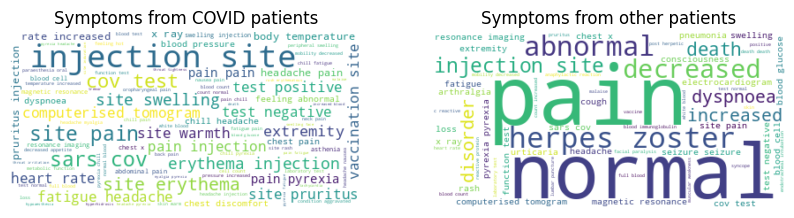

In [47]:
# Assuming 'dff' is your DataFrame containing the data
# Assuming 'stopwords' is your list of stopwords

# Create a WordCloud instance
wc = WordCloud(background_color='white', stopwords=stopwords)

fig, ax = plt.subplots(1,2, figsize = (10,10), sharey = True)

var = 'VAX_TYPE'
# Create the WordCloud from the combined strings
combined_text = ' '.join(dff.bSympt[dff[var] == 'COVID19'])
wc.generate(combined_text)

# Display the WordCloud
ax[0].imshow(wc, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title('Symptoms from COVID patients')

# Create the WordCloud from the combined strings
combined_text = ' '.join(dff.bSympt[dff[var] != 'COVID19'])
wc.generate(combined_text)

# Display the WordCloud
ax[1].imshow(wc, interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title('Symptoms from other patients')

plt.show()


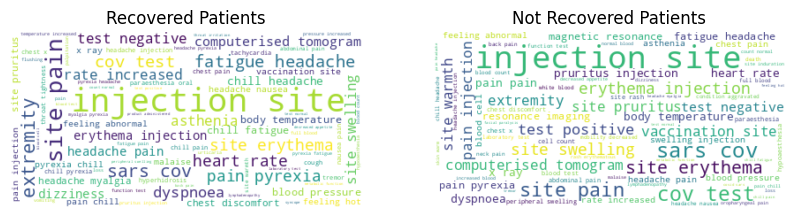

In [39]:
# Assuming 'dff' is your DataFrame containing the data
# Assuming 'stopwords' is your list of stopwords

# Create a WordCloud instance
wc = WordCloud(background_color='white', stopwords=stopwords)

fig, ax = plt.subplots(1,2, figsize = (10,10), sharey = True)

var = 'RECOVD'
# Create the WordCloud from the combined strings
combined_text = ' '.join(dff.bSympt[dff[var] == 'Y'])
wc.generate(combined_text)

# Display the WordCloud
ax[0].imshow(wc, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title('Recovered Patients')

# Create the WordCloud from the combined strings
combined_text = ' '.join(dff.bSympt[dff[var] != 'Y'])
wc.generate(combined_text)

# Display the WordCloud
ax[1].imshow(wc, interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title('Not Recovered Patients')

plt.show()


In [32]:
# Split the data into training and testing sets
dummy = dff.copy()
dummy.dropna(subset=['bSympt', 'RECOVD'], inplace = True)
dummy.reset_index(drop = True, inplace = True)
X = dummy['bSympt']
y = dummy['RECOVD'].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

classifier = LogisticRegression()
classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_tfidf)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.58
              precision    recall  f1-score   support

           N       0.59      0.66      0.62      3847
           U       0.57      0.22      0.32      1900
           Y       0.56      0.67      0.61      3633

    accuracy                           0.58      9380
   macro avg       0.57      0.52      0.52      9380
weighted avg       0.57      0.58      0.56      9380



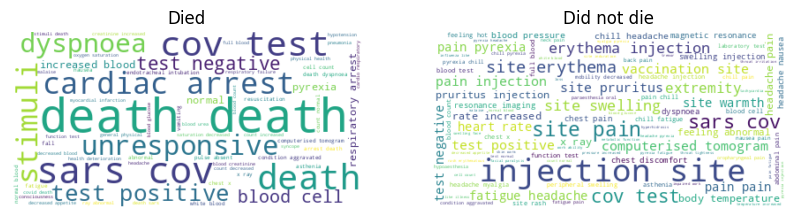

In [38]:
# Assuming 'dff' is your DataFrame containing the data
# Assuming 'stopwords' is your list of stopwords

# Create a WordCloud instance
wc = WordCloud(background_color='white', stopwords=stopwords)

fig, ax = plt.subplots(1,2, figsize = (10,10), sharey = True)

var = 'DIED'
# Create the WordCloud from the combined strings
combined_text = ' '.join(dff.bSympt[dff[var] == 'Y'])
wc.generate(combined_text)

# Display the WordCloud
ax[0].imshow(wc, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title('Died')

# Create the WordCloud from the combined strings
combined_text = ' '.join(dff.bSympt[dff[var] != 'Y'])
wc.generate(combined_text)

# Display the WordCloud
ax[1].imshow(wc, interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title('Did not die')

plt.show()


In [43]:
# Split the data into training and testing sets
dummy = dff.copy()
dummy.DIED[dummy.DIED != 'Y'] = 'N'
dummy.dropna(subset=['bSympt', 'DIED'], inplace = True)
dummy.reset_index(drop = True, inplace = True)
X = dummy['bSympt']
y = dummy['DIED'].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

classifier = LogisticRegression()
classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_tfidf)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.99
              precision    recall  f1-score   support

           N       0.99      1.00      0.99      9666
           Y       0.97      0.80      0.87       571

    accuracy                           0.99     10237
   macro avg       0.98      0.90      0.93     10237
weighted avg       0.99      0.99      0.99     10237



In [24]:
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 35.4 MB/s eta 0:00:00


In [75]:
text = dff['SYMPTOM_TEXT'][1]
# Convert text to lowercase
text = text.lower()

# Tokenize the sentence
text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
text = re.sub(r'\d+', '', text)       # Remove numbers
textblb = TextBlob(text)
corrected_tokens = textblb.correct().string

corrected_tokens = word_tokenize(corrected_tokens)

# Remove stopwords
corrected_tokens = [word for word in corrected_tokens if word not in stopwords]

#Refine the list from None elements:
corrected_tokens = [token for token in corrected_tokens if token is not None]
#Normalize words
#corrected_tokens = [stemmer.stem(word) for word in corrected_tokens]
corrected_tokens = [lemmatizer.lemmatize(word) for word in corrected_tokens]

print(corrected_tokens)


['approximately', 'min', 'post', 'vaccination', 'administration', 'patient', 'demonstrated', 'sob', 'anxiousness', 'possessed', 'time', 'event', 'heart', 'sound', 'normal', 'lung', 'sound', 'clear', 'vital', 'within', 'normal', 'limit', 'patient', 'liner', 'continuous', 'flow', 'consecutive', 'nebulized', 'albuterol', 'treatment', 'administered', 'approximately', 'hour', 'post', 'reaction', 'patient', 'sob', 'anxiousness', 'subsided', 'patient', 'stated', 'feel', 'much', 'better']


In [77]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker  # Install the 'pyspellchecker' package
from textblob import TextBlob

# Initialize NLTK's Porter Stemmer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Preprocess the text
def preprocess_text(text):
  if type(text) != str:
    text = ''

  # Convert text to lowercase
  text = text.lower()

  # Tokenize the sentence
  text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
  text = re.sub(r'\d+', '', text)       # Remove numbers
  #textblb = TextBlob(text)
  #text = textblb.correct().string
  corrected_tokens = word_tokenize(text)

  # Remove stopwords
  corrected_tokens = [word for word in corrected_tokens if word not in stopwords]

  #Refine the list from None elements:
  corrected_tokens = [token for token in corrected_tokens if token is not None]
  #Normalize words
  #corrected_tokens = [stemmer.stem(word) for word in corrected_tokens]
  corrected_tokens = [lemmatizer.lemmatize(word) for word in corrected_tokens]

  output = ' '.join(corrected_tokens)
  return output

# Apply preprocessing to the DataFrame
dff['processed_text'] = np.repeat(np.nan, len(dff))
for ix in range(len(dff)):
  dff['processed_text'][ix] = preprocess_text(dff.SYMPTOM_TEXT[ix])

# Combine all processed text into a single string
combined_text = ' '.join(dff['processed_text'])


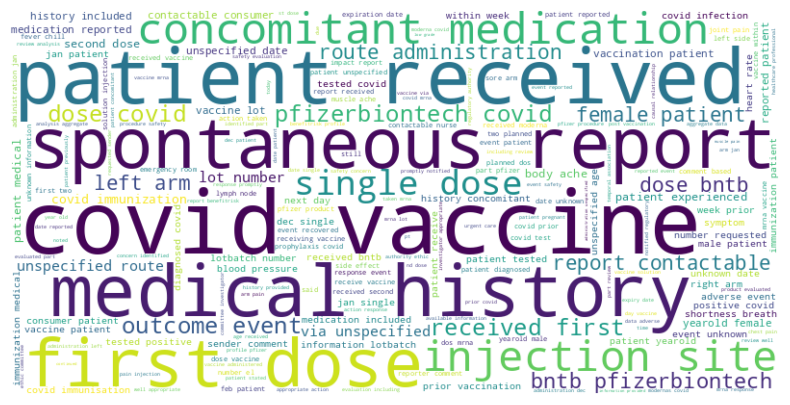

In [78]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()